In [1]:
from finance_news_scraper.mongo_client import MongoDBClient
from finance_stock_scraper.QuestClient import QuestClient
from finance_stock_scraper.TickerRepository import TickerRepository
from finance_stock_scraper.model.Ticker import Ticker

import matplotlib.pyplot as plt
import pandas as pd

In [2]:
MONGO_IP = "192.168.2.119"

mongoClient = MongoDBClient(host=MONGO_IP)
questClient = QuestClient(host=MONGO_IP,port=9001)
tickerRepository = TickerRepository(questClient)


In [9]:
#Define the ticker
ticker = Ticker("AAPL","NASDAQ")
#Get data from QuestDB
df_daily = tickerRepository.get_values(tickers=ticker,interval="1d",values=["close","volume"])
df_minutly = tickerRepository.get_values(tickers=ticker,interval="5m",values=["close","open","volume"])

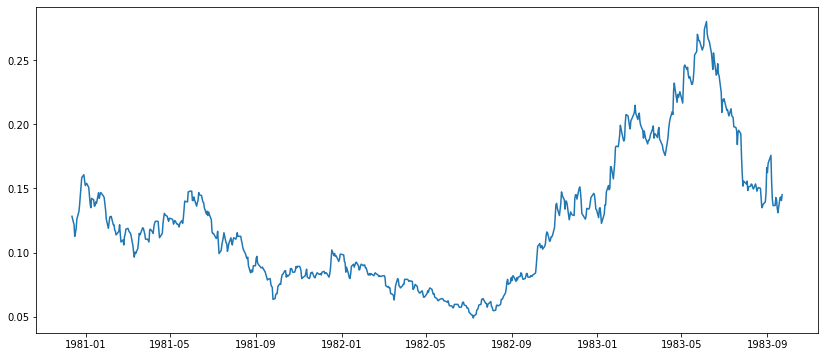

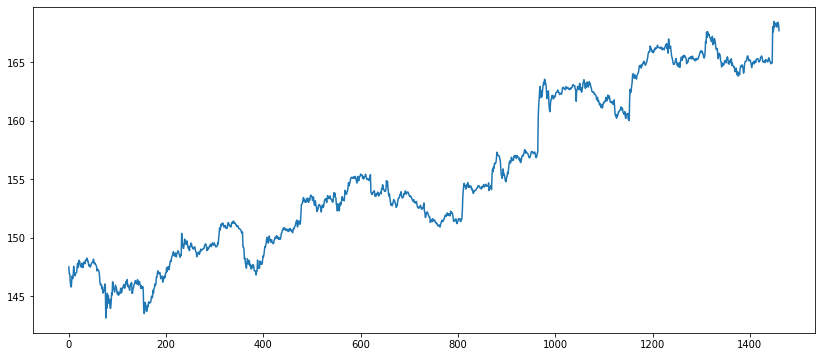

In [11]:
plt.figure(figsize=(14,6))
plt.plot(df_daily['close'])
plt.show()

plt.figure(figsize=(14,6))
plt.plot(range(len(df_minutly['close'])),df_minutly['close'])
plt.show()

In [12]:
for article in mongoClient.get_articles(["GOOGL"]):
    print(f"{article['date']}: {article['url']}")

2022-08-10 13:19:20: https://www.marketscreener.com/news/latest/Wall-St-set-for-gains-after-soft-inflation-data-eases-rate-hike-bets--41268160/
2022-08-10 13:11:09: https://shanghai.ist/2022/08/10/artificial-intelligence-for-drug-development-and-discovery-market-to-witness-massive-growth-by-2029-alphabet-inc-atomwise-inc/
2022-08-10 12:30:00: https://www.prnewswire.com/news-releases/investing-in-quantum-computing-what-every-investor-needs-to-know-301603175.html
2022-08-10 12:00:03: https://www.forbes.com/sites/greatspeculations/2022/08/10/alphabet-google-stock-missed-the-street-expectations-in-q2-whats-next/
2022-08-10 11:26:00: https://www.reuters.com/markets/europe/futures-tick-higher-investors-brace-inflation-data-2022-08-10/
2022-08-10 11:15:00: https://www.fool.com/investing/2022/08/10/which-company-is-winning-the-cloud-computing-war/
2022-08-10 10:30:00: https://www.globenewswire.com/news-release/2022/08/10/2495600/0/en/Cloud-Analytics-Revenue-through-BFSI-to-Register-14-9-CAGR-d

In [13]:
for sentiment in mongoClient.get_sentiments(["GOOGL"]):
    print(f"{sentiment['date']}: {sentiment['sentiment']}")

2022-08-09 20:57:31: {'class': 1, 'probabilities': [0.0794825553894043, 0.0353773832321167, 0.885140061378479]}
2022-08-09 19:18:21: {'class': 1, 'probabilities': [0.025492984801530838, 0.04835597798228264, 0.9261509776115417]}
2022-08-09 16:24:45: {'class': 1, 'probabilities': [0.03322708234190941, 0.023515133187174797, 0.9432578086853027]}
2022-08-09 13:55:00: {'class': 1, 'probabilities': [0.06269795447587967, 0.22567003965377808, 0.7116320133209229]}
2022-08-09 13:51:23: {'class': 1, 'probabilities': [0.09529203921556473, 0.014364033937454224, 0.8903439044952393]}
2022-08-09 13:15:10: {'class': 1, 'probabilities': [0.1774207055568695, 0.010798675008118153, 0.811780571937561]}
2022-08-09 13:10:00: {'class': 0, 'probabilities': [0.039370179176330566, 0.49807533621788025, 0.4625544250011444]}
2022-08-09 13:04:55: {'class': 0, 'probabilities': [0.009362680837512016, 0.9736909866333008, 0.016946349292993546]}
2022-08-09 13:01:08: {'class': 0, 'probabilities': [0.08590111136436462, 0.591